# Desafio Data T10

<center> <h1> Importar livrarias necessárias para a análise</h1> </center>

In [179]:
# !pip install plotly

In [180]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics
from IPython.display import display, HTML
from sklearn.metrics import roc_curve, roc_auc_score

In [181]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h1 style="text-align:center"> Leitura dos dados</h1>

In [182]:
df = pd.read_csv('data/campaigns.csv', index_col=0)

<h1 style="text-align:center">Análise descritiva dos dados</h1>

<p style="font-size:18px;text-align:justify">Vamos começar nossa análise olhando para qual profissão tem tendência a fazer um empréstimo.</p>

In [183]:
df_housing_loan_all = df[(df.housing=="yes") | (df.loan =="yes")]
d = pd.DataFrame(df_housing_loan_all.groupby(['job'],as_index=True).size().sort_values(ascending=True))
d.columns = ['Nro Clientes']
fig = px.bar(d, y=d.index,text='Nro Clientes',labels={'job':'Job'}, x='Nro Clientes', orientation='h',title='Número de clientes com algum tipo de empréstimo segundo seu trabalho')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

<p style="font-size:18px;text-align:justify">No gráfico anterior pode-se ver que "Blue-Collar" e "Management" são os trabalhos que mais assinaram algum tipo de empréstimo (seja do tipo Loan ou Housing). Em contrapartida, "Student" e "Housemaid" são as profissões com menor frequência de clientes. Será que essa distribuição é mantida para os dois tipos de empréstimo?</p>

In [184]:
df_housing = df[(df.housing=="yes")]
df_housing = df_housing.job.value_counts().sort_values(ascending=True)
df_loan = df[df.loan=="yes"]
df_loan = df_loan.job.value_counts().sort_values(ascending=True)
df_combined = pd.concat([df_loan, df_housing], axis=1)
df_combined.columns=['Loan','Housing']
fig =px.bar(df_combined, title='Número de clientes por trabalho e tipo de empréstimo',text='value',labels={'value':'Nro Clientes','index':'Job','variable':'Tipo de Empréstimo'}, y= df_combined.index, x=['Loan','Housing'], barmode='group', orientation='h')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

<p style="font-size:18px;text-align:justify"> No gráfico anterior vemos que a distribuição é mantida para a profissão "Blue-collar", agora para a profissão "Management" vemos que ela é superada no tipo de empréstimo Loan pela profissão de "Technician". Isto nos da noções de qual tipo de empréstimo é mais adequado ao levar em consideração a profissão do cliente. Agora, dado que nosso interesse está nos clientes que poderiam assinar um deposito, vamos olhar as caracteristicas deles.</p>

In [185]:
d={'Assinaram':['No','Yes'], 'Values': df.y.value_counts()}
df_target=pd.DataFrame(data=d)
#df_target.plot(autopct='%1.0f%%',kind='pie', labeldistance=1.2)
px.pie(df_target, values='Values', names='Assinaram', title='Proporção de clientes que assinaram um depósito')

<p style="font-size:18px;text-align:justify">A primeira característica que achamos é que uma proporção "baixa" (aproximadamente 12%) dos clientes contatados aceitaram assinar um depósitos. Vejamos como é o comportamento nas outras variáveis dos clientes que tiveram adesão positiva.</p>

In [186]:
df_job_target = df[(df.y=="yes")]
d = pd.DataFrame(df_job_target.groupby(['job'],as_index=True).size().sort_values(ascending=True))
d.columns = ['Nro Clientes']
fig = px.bar(d, y=d.index,title='Número de clientes que assinaram um depósito segundo seu trabalho',text='Nro Clientes',labels={'job':'Job'} ,x='Nro Clientes', orientation='h')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

<p style="font-size:18px;text-align:justify">Ao analisar o número de clientes que assinaram um depósito nas diferentes profissões, vemos que igualmente aos clientes com algum empréstimo, as profissões com maior número de clientes são Management, Technician e Blue-Collar. Desta vez, Management é a profissão com maior aderença a assinar um deposito. Vejamos agora como é essa distribuição discriminando por o nível educativo.</p>

In [187]:
df_education_target = df[(df.y=="yes")]
d = pd.DataFrame(df_education_target.groupby(['education'],as_index=True).size().sort_values(ascending=True))
d.columns = ['Nro Clientes']
fig = px.bar(d, y=d.index,title='Número de clientes que assinaram um depósito segundo seu nível educativo',text='Nro Clientes',labels={'education':'Educação'} ,x='Nro Clientes', orientation='h')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

<p style="font-size:18px;text-align:justify">Olhando para o nível educativo encontramos que o maior número de clientes que assinaram um depósito são aqueles que tem nível educativo superior (Secondary e tertiary). Vejamos como é sua distribuição quando olhamos para o tipo de profissão.</p>

In [188]:
df_education_job_target = df[(df.y=="yes")].groupby(['education','job']).size().sort_values(ascending=False)
df_education_job_cross = df_education_job_target.reset_index(name='count')
px.bar(df_education_job_cross, y='count', x='education',title='Número de clientes que assinaram um depósito segundo seu nível educativo e tipo de profissão',color='job',labels={'count':'Nro Clientes','job':'Job','education':'Educação'}, barmode='group')
#sns.catplot(x = "education",y = "count",hue = "job",data = df_education_job_cross, kind = "bar")

<p style="font-size:18px;text-align:justify">Da gráfica anterior podemos notar que clientes com nível educativo tertiary geralmente são de profissão management, ja nos clientes de nível educativo secondary a maior presença é das profissões technician e admin, e para os clientes com nível educativo primary Blue-collar e retired. Vejamos agora o saldo médio anual dos clientes.</p>

In [189]:

px.box(df,y='y', x='balance', title='Distribuição do saldo médio anual segundo sua intenção de assinar um depósito', points= 'suspectedoutliers',labels={'y':'Assinaram depósito'})


<p style="font-size:18px;text-align:justify">Na gráfica acima vemos que a distribuição do saldo médio entre os clientes que decidiram ou não assinar um depósito parece ser similar, com diferença principalmente nos valores outliers (valores atípicos). Demos uma olhada agora na faixa etária deles.</p>

In [190]:
# create the bins
counts, bins = np.histogram(df.age)
bins = 0.5*(bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, title='Distribuição da idade dos clientes',labels={'x':'Idade', 'y':'Número de Clientes'})
fig.show()

<p style="font-size:18px;text-align:justify"> Vemos que a maior proporção dos clientes estão na faixa etária entre 30 e 60 anos. Vejamos como é a distribuição nos clientes com adesão positiva à decisão de assinar um depósito.</p>

In [191]:
px.box(df,y='y', x='age', title='Distribuição da idade dos clientes segundo sua decisão de assinar um depósito', points= 'suspectedoutliers',labels={'y':'Assinaram depósito'})

<p style="font-size:18px;text-align:justify">No bloxplot acima vemos que a distribuição da idade é similar nos clientes que assinaram e os que não assinaram um depósito. Isso poderia nos indicar que a idade não tem impacto significativo na adesão positiva ou negativa de um depósito. Vejamos agora como tem sido o contato com os clientes.</p>

In [192]:
campaign_summary =pd.DataFrame(df[(df.y=="yes")]['campaign'].describe()).T
HTML(campaign_summary.to_html())

<p style="font-size:18px;text-align:justify">Na tabela acima vemos que em média são feitos 2.14 contatos nos clientes que assinaram um deposito, além disso vemos que só um 25% deles foi contatado mais de 3 vezes. Na gráfica a seguir apresentamos a distribuição do número de contatos dos clientes que não assinaram um depósito.</p

In [193]:

px.box(df,y='y', x='campaign', title='Distribuição do número de contatos segundo sua intenção de assinar um depósito',points= 'suspectedoutliers',labels={'campaign':'Nro de contatos','y':'Assinaram depositos'})


<p style="font-size:18px;text-align:justify">Como argumentado acima, considerando a distribuição do número de ligações para os clientes que aderiram, devem ser feitas, em média, 2 ligações. Apesar do número máximo de ligações no grupo de clientes que a adesão foi positiva ter sido maior que 4, podemos observar pela gráfica acima que esses valores são outliers (dados com comportamento diferente dos demais). Portanto, pela distribuição quantílica mostrada na tabela anterior e pelo boxplot (gráfica acima) apresentado, parece que o número sugerido de contatos seja no máximo 4 ligações. Essa ideia pode-ser baseada também na distribuição dos clientes que não se aderiram a assinar um depósito, note que a distribuição deles é similar a dos clientes que tiveram uma adesão positiva, a diferença está nos valores outliers. Demos uma olhada na duração desses contatos.</p>

In [ ]:
px.box(df,y='y', x='duration', title='Distribuição da duração do último contatodo segundo sua intenção de assinar um depósito',points= 'suspectedoutliers',labels={'duration':'Segundos','y':'Assinaram depositos'})



<p style="font-size:18px;text-align:justify">No gráfico anterior podemos ver que o tempo no último contato nos clientes que assinaram um deposito foi maior ao tempo dos que não assinaram.</p>

In [ ]:
df_education_job_target = df.groupby(['y','poutcome']).size().sort_values(ascending=False)
df_education_job_cross = df_education_job_target.reset_index(name='count')
px.bar(df_education_job_cross, y='count', x='y',title='Número de clientes que assinaram um depósito dado o resultado da campanha anterior',color='poutcome',labels={'count':'Nro Clientes','poutcome':'Campanha prévia','y':'Adesão'}, barmode='group')
#sns.catplot(x = "education",y = "count",hue = "job",data = df_education_job_cross, kind = "bar")

<p style="font-size:18px;text-align:justify">O gráfico acima da a ideia de que um cliente é mais propenso a assinar um depósito quando ele já participou com sucesso em campanhas anteriores. Para fixar melhor essas ideias vamos ajustar um modelo analítico, mais especificamente um modelo logístico que nos indique quais variáveis estão impactando estatisticamente a decisão de se assinar um depósito.</p>

<h1 style="text-align:center">Ajuste do modelo</h1>

<p style="font-size:18px;text-align:justify">Para começar vamos deixar as variáveis num formato adequado:</p>

In [ ]:
# Preparação dos dados para o modelo
var2dummi = df[['job','marital','education','default','housing','loan','contact','day','month','poutcome']]
num_vars = df[['age','balance','duration','previous','pdays','campaign']]
X = pd.get_dummies(data=var2dummi, columns=['job','marital','education','default','housing','loan','contact','month','poutcome'])
X2model = pd.concat([num_vars, X], axis=1)
y = pd.DataFrame(df.apply(lambda X: 1 if X.y == 'yes' else 0, axis=1))
y.columns=['y']

<p style="font-size:18px;text-align:justify">Agora vamos usar a função RFE() para seleccionar as melhores features:</p>

In [ ]:
#Seleção do modelo
logisticRegr = LogisticRegression()
rfe = RFE(logisticRegr,20)
rfe = rfe.fit(X2model, df.y)
X_rfe_best = X2model.columns[rfe.support_]
X_selected = X2model[X_rfe_best]
print(X_rfe_best)

Index(['job_housemaid', 'job_retired', 'job_student', 'housing_yes',
       'loan_yes', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')


<p style="font-size:18px;text-align:justify">Com as variáveis seleccionadas pela função, vamos agora a dividir os dados para treinar o modelo, posteriormente vamos ajustá-lo:</p>

In [ ]:
#Ajuste do modelo
#Divisão da amostra para ajustar o modelo
x_train, x_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=0)
logit_model=sm.Logit(y_train,x_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.308021
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.158     
Dependent Variable: y                AIC:              18839.7423
Date:               2020-06-12 14:26 BIC:              19006.2630
No. Observations:   30517            Log-Likelihood:   -9399.9   
Df Model:           19               LL-Null:          -11159.   
Df Residuals:       30497            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
job_housemaid    -0.5317   0.1367  -3.8886 0.0001 -0.7997 -0.2637
job_retired       0.3707   0.0734   5.0522 0.0000  0.2269  0.5145


<p style="font-size:18px;text-align:justify">A tabela acima vemos que as variáveis que estão impactando significativamente a decisão de se aderir ou não num depósito são o mês, se o cliente já tem um empréstimo (Housing ou Loan), a profissão e o resultado em campanhas anteriores. Além disso, o modelo diz que Setembro, Outubro e Dezembro são meses que tem impacto positivo na decisão de se aderir positivamente num depósito. Vejamos agora a qualidade do ajuste do modelo.</p>

<p style="font-size:18px;text-align:justify">Embora a métrica de acurácia não seja ideal quando o dataset não é proporcional para cada classe da nossa variável target, nós apresentamos com fins ilustrativos.</p>

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
valores_pred = logreg.predict(x_test)
print('Acuracia do modelo : {:.2f}'.format(logreg.score(x_test, y_test)))

Acuracia do modelo : 0.90


<p style="font-size:18px;text-align:justify">Vejamos agora a precisão do modelo:</p>

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, valores_pred)
precision= (confusion_matrix[0][0]+ confusion_matrix[1][1])/(confusion_matrix[0][0]+confusion_matrix[0][1]+ confusion_matrix[1][0]+ confusion_matrix[1][1])
print('Precisão do modelo : {:.2f}' .format(precision*100))


Precisão do modelo : 89.70


<p style="font-size:18px;text-align:justify">Vemos que o modelo tem uma precisão aceitável. Vejamos agora o que nos diz sobre o modelo a curva ROC:</p>

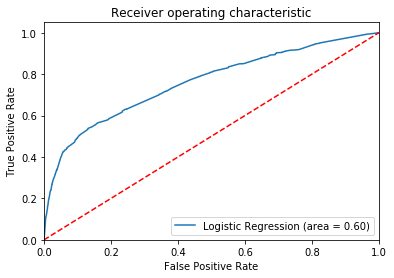

In [ ]:

logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

<p style="font-size:18px;text-align:justify">O ajuste da curva ROC apresentou uma área de 0.6. Dado que esta é uma métrica mais adequada para datasets com classes desproporcionais e que muitos autores indicam valores acima de 0.7 como aceitáveis para um modelo, é indicado revisar o ajuste do modelo ou ajustar outro modelo mais adequado. Por exemplo, note como o ajuste melhora quando deixamos todas as variáveis.</p>

In [ ]:
#Modelo com todas as variáveis
x_train, x_test, y_train, y_test = train_test_split(X2model, y, test_size=0.25, random_state=0)
logit_model=sm.Logit(y_train,x_train)
result = logit_model.fit()
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
valores_pred = logreg.predict(x_test)
logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

<p style="font-size:18px;text-align:justify">Deixar todas as variáveis incrementou a área embaixo da curva em 0.06, isto se aproxima mais a um modelo aceitável. A seguir construimos o conjunto de dados com os valores preditos.</p>

In [ ]:
df_with_pred= x_test
df_with_pred['y_pred']= valores_pred
df_with_pred['y']= y_test
df_with_pred.to_csv("~/data/df_previsão.csv",index=False, header=True)

<h1 style="text-align:center">Conclusões e sugestões</h1>

<p style="font-size:18px;text-align:justify">Do modelo ajustado vimos que as variáveis mês, housing, loan, job e poutcome impactam significativamente a decisão de adesão num depósito, contudo, vale a pena notar que só alguns níveis dessas variáveis impactam positivamente. Por exemplo, fazer contacto nos meses de março, outubro, setembro e dezembro, ser estudante ou aposentado e ter tido sucesso em campanhas anteriores são fatores que aumentam positivamente a probabilidade de adesão de um cliente. Além disso, note que fazer mais de quatro contatos com o cliente não aumenta a probabilidade de ele assinar um depósito e sim está-se incorrendo em despesas desnecessárias. Assim, uma sugestão seria fazer no máximo quatro contatos com o cliente e procurar que estos contatos durem mais de 244 segundos, ja que como vimos no boxplot da duração dos contatos, 75% dos clientes que assinaram deposito tiveram contatos com tempos superiores a 244 segundos. Procure que o contato seja nos meses indicados com maior probabilidade de adesão</p>

<p style="font-size:18px;text-align:justify">
Note que é importante antes de começar a campanha fazer uma seleção detalhada dos clientes, por exemplo, filtrar aqueles que tem um crédito em default e aqueles que rejeitaram mais de uma vez (poutcome="failure") em campanhas anteriores.</p>